In [1]:
import re
import os
import numpy as np
import cPickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        y : array-like, shape = [n_samples]
            Vector of target class labels.
        Returns
        -------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
        return out

with open('model.pkl', 'rb') as fid:
    pipe = cPickle.load(fid)

In [60]:
def createpredictmatrix(features, kmer):
	stat = pd.read_csv(features, sep=",")
	kmer = pd.read_csv(kmer, sep="\t", header = None) 
	df = pd.concat([stat.reset_index(drop=True), kmer], axis=1) # concat kmer and stat matrix
	df_complete = df.dropna(axis=1) # remove columns with NAN
	return df_complete

dat = createpredictmatrix('dat/input.features.clear2.csv', 'dat/input.features.kmer')
X = dat.drop(dat.columns[[0]], 1) # remove label

In [61]:
X

,length,ncodons,nUnk,nG,nA,nT,nC,nN,nGC,nAT,...,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727
0,100,33,0,20,34,21,25,0,45,55,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
1,100,33,0,21,34,20,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
2,100,33,0,21,34,19,26,0,47,53,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
3,100,33,0,21,34,20,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
4,100,33,0,21,33,21,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
5,100,33,0,21,33,21,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
6,100,33,0,21,33,21,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
7,100,33,0,21,33,21,25,0,46,54,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
8,100,33,0,21,34,21,24,0,45,55,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0
9,100,33,0,21,33,22,24,0,45,55,...,0.0,0,0.0,0,0,0.0,0,0,0.0,0.0


In [69]:
label = {0:'chromosomal', 1:'plasmid'}
#predictons = pipe.predict(X)
probabilities = pipe.predict_proba(X)[:,1]


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


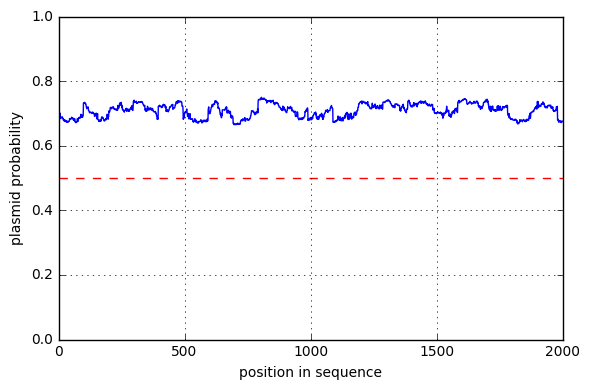

In [95]:
import matplotlib.pyplot as plt

plt.plot(probabilities, 'b-')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axis([0, 2000, 0, 1])
plt.grid()
plt.xlabel('position in sequence')
plt.ylabel('plasmid probability')
plt.tight_layout()
    
plt.show()

In [100]:
from Bio import SeqIO

fasta_file = 'dat/input.fasta'

for seq_record in SeqIO.parse(fasta_file, "fasta"):
    sequence = str(seq_record.seq).upper()
    print(len(sequence))
        

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
175


In [71]:
list(probabilities)

[0.69617657435802371,
 0.68675240777316515,
 0.68824226190796922,
 0.68660061554928919,
 0.68582136885182143,
 0.68590777301886963,
 0.70156735856483377,
 0.68589377807001706,
 0.6842678262342724,
 0.68418880897303946,
 0.68643705866847993,
 0.68858348433075534,
 0.68855650995084894,
 0.68853618660753024,
 0.68973491183458824,
 0.68995069462182013,
 0.68612729431068542,
 0.68446333146699112,
 0.68332986995361067,
 0.68480693867928366,
 0.67835701899397749,
 0.67838004585064404,
 0.68118064392741084,
 0.67897574933059379,
 0.67662487588482501,
 0.67781438573936603,
 0.67958150526493488,
 0.67498145829915057,
 0.6786627274854532,
 0.67612419034895554,
 0.67615794877297086,
 0.67636432920184275,
 0.67448247940379868,
 0.67324595860507264,
 0.67686943563334312,
 0.67312452106559617,
 0.6732353302533115,
 0.67340575681683312,
 0.67322546749706991,
 0.6754668546279895,
 0.67555071710670511,
 0.67555507829461447,
 0.67651551804240329,
 0.676412804367577,
 0.6839361728374852,
 0.68179714696191

In [8]:
label = {0:'chromosomal', 1:'plasmid'}

for index, row in X.iterrows():
    print('Prediction: %s (%.2f%%)' %\
        (label[pipe.predict(X)[index]], pipe.predict_proba(X)[index].max()*100))

        
#print('Prediction: %s\nProbability: %.2f%%' %\
#      (label[pipe.predict(X)[6]], pipe.predict_proba(X)[6].max()*100))

#pipe.predict_proba(X_test)[0].max()

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (67.69%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


Prediction: plasmid (67.41%)


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (68.98%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (66.74%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


Prediction: plasmid (64.22%)


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (66.60%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (67.03%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


Prediction: plasmid (68.91%)


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s


Prediction: plasmid (69.33%)


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s


Prediction: plasmid (68.95%)


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


In [ ]:
X